In [1]:
import fenics as fe
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from mshr import *
from gaussian_process import *

# fe.PETScOptions.set("snes_linesearch_monitor", "")
fe.PETScOptions.set("snes_linesearch_type", "bt")

In [2]:
# Define the necessary parameters
N_SIM = 2    # number of simulations
N_F = 5      # number of frequencies
mu = 0.0   
sigma = 5.0
N_POINTS_P_AXIS = 100
TIME_STEP_LENGTH = 0.2
TOTAL_TIME = 2
N_TIME_STEPS = np.floor(TOTAL_TIME/TIME_STEP_LENGTH).astype(int)
KINEMATIC_VISCOSITY = fe.Constant(0.01)
time_vector = np.arange(0.0, TOTAL_TIME, TIME_STEP_LENGTH)

In [3]:
# Generate the gaussian BCs
np.random.seed(15)
alphaM = np.random.normal(mu, sigma, (N_SIM, N_F))
np.save('alphaM.npy',alphaM)

In [4]:
# Create XDMF files (one for all the simulations) -> current focus only on velocity
xdmffile_u = fe.XDMFFile('lid_cavity_u_nl.xdmf')
xdmffile_p = fe.XDMFFile('lid_cavity_p_nl.xdmf')
xdmffile_u.parameters["flush_output"] = True
xdmffile_u.parameters["functions_share_mesh"] = True
xdmffile_p.parameters["flush_output"] = True
xdmffile_p.parameters["functions_share_mesh"] = True

In [5]:
# Define an expression for the BC u_t
class u_t_Expression(fe.UserExpression):
    def __init__(self, t, alphav, **kwargs):
        super().__init__(**kwargs)
        self.t = t
        self.alphav = alphav
    def eval(self, value, x):
        value[0] = eval_u_t(self.t, self.alphav, TOTAL_TIME)
        value[1] = 0.0
    def value_shape(self):
        return (2,) 

In [6]:
class BottomVertex(fe.SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0]) < fe.DOLFIN_EPS and abs(x[1]) < fe.DOLFIN_EPS)

In [7]:
def solve_problem(alphav, num_sim):

    
    # Plot the u_t used for the i-th simulation over 2 periods
    t_v = np.linspace(0, 2*TOTAL_TIME, 1000) 
    u_plot = eval_u_t(t_v, alphav, TOTAL_TIME)
    plt.figure(figsize=(10, 5))
    plt.plot(t_v, u_plot)
    plt.xlabel('Time')
    plt.ylabel('u(t)')
    plt.title('u(t) current simulation')
    plt.grid(True)
    plt.show()
    
    # mesh = fe.UnitSquareMesh(N_POINTS_P_AXIS, N_POINTS_P_AXIS, "crossed")
    domain = Rectangle(fe.Point(0., 0.), fe.Point(1., 1.))
    mesh = generate_mesh(domain, N_POINTS_P_AXIS)
   
    # Taylor-Hood Elements. 
    element_v = fe.VectorElement("Lagrange", mesh.ufl_cell(), 2)
    element_p = fe.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    W = fe.FunctionSpace(mesh, fe.MixedElement(element_v, element_p))
    V = fe.FunctionSpace(mesh, element_v)
    Q = fe.FunctionSpace(mesh, element_p)

    # Define trial functions
    vq = fe.TestFunction(W)
    delta_up = fe.TrialFunction(W)
    (v, q) = fe.split(vq)

    up = fe.Function(W)
    (u, p) = fe.split(up)

    up_prev = fe.Function(W)
    (u_prev, _) = fe.split(up_prev)

    # Define boundary conditions
    g = u_t_Expression(0.0, alphav) 
    noslip = fe.DirichletBC(W.sub(0), (0, 0), "x[0] < DOLFIN_EPS || x[0] > 1.0 - DOLFIN_EPS || x[1] < DOLFIN_EPS")
    lid = fe.DirichletBC(W.sub(0), g, "x[1] > 1.0 - DOLFIN_EPS")
    pref = fe.DirichletBC(W.sub(1), 0, "x[0] < DOLFIN_EPS && x[1] < DOLFIN_EPS", "pointwise")

    bc = [noslip, lid, pref]

    # Stabilization if needed
    # h = fe.CellDiameter(mesh)
    # alpha_u = fe.Constant(1.)
    # delta_u = alpha_u*(h**2)
    # alpha_p = fe.Constant(1.)
    # delta_p = alpha_p*(h**2)
    # rho = fe.Constant(0.)
    # rho =   0 -> SUPG (Streamline updwind Petrov Galerkin)
    # rho =   1 -> GALS (Galerkin least squares)
    # rho = - 1 -> Douglas-Wang

    # Tentative velocity step
    F = fe.inner(u, v)/fe.Constant(TIME_STEP_LENGTH)*fe.dx \
        - fe.inner(u_prev, v)/fe.Constant(TIME_STEP_LENGTH)*fe.dx \
        + fe.inner(fe.grad(u) * u, v) * fe.dx \
        + KINEMATIC_VISCOSITY * fe.inner(fe.grad(u), fe.grad(v)) * fe.dx \
        - fe.div(v) * p * fe.dx \
        - q * fe.div(u) * fe.dx 
        # + fe.inner(- KINEMATIC_VISCOSITY*fe.div(fe.grad(u)) + fe.grad(p),
        #            -  rho*fe.delta_u*KINEMATIC_VISCOSITY*fe.div(fe.grad(v)) + delta_p*fe.grad(q))*fe.dx  # Stabilization term 

    J = fe.derivative(F, up, delta_up)

    snes_solver_parameters = {"nonlinear_solver": "snes",
                            "snes_solver": {"linear_solver": "mumps",
                                            "maximum_iterations": 20,
                                            "report": False,
                                            "error_on_nonconvergence": True}}

    (u, p) = up.split()
    u.rename("u", "")
    p.rename("p","")
    xdmffile_u.write(u, num_sim*TOTAL_TIME)
    xdmffile_p.write(p, num_sim*TOTAL_TIME)
    
    for i in tqdm(range(1, N_TIME_STEPS)):

        # Go back to "physical" time in order to correctly update the BC
        t = i*TIME_STEP_LENGTH
        g.t = t

        # KINEMATIC_VISCOSITY.assign(1.)
        problem = fe.NonlinearVariationalProblem(F, up, bc, J)
        solver  = fe.NonlinearVariationalSolver(problem)
        solver.parameters.update(snes_solver_parameters)
        solver.solve()

        # Store the solution in up_prev
        fe.assign(up_prev, up)

        # Save
        (u, p) = up.split()
        u.rename("u", "")
        p.rename("p","")
        xdmffile_u.write(u, t+num_sim*TOTAL_TIME)
        xdmffile_p.write(p, t+num_sim*TOTAL_TIME)
        

In [8]:
def main():
    for i in range(N_SIM):
        alphav = alphaM[i, :]
        solve_problem(alphav, i) 

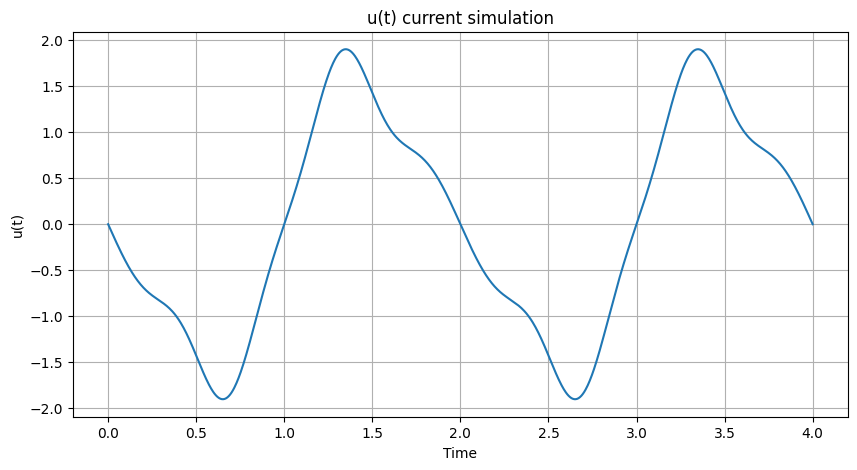

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:08<01:07,  8.39s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:16<00:57,  8.18s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:24<00:49,  8.18s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:32<00:41,  8.25s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:41<00:32,  8.24s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [00:49<00:24,  8.25s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [00:57<00:16,  8.22s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:05<00:08,  8.22s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:14<00:00,  8.23s/it]


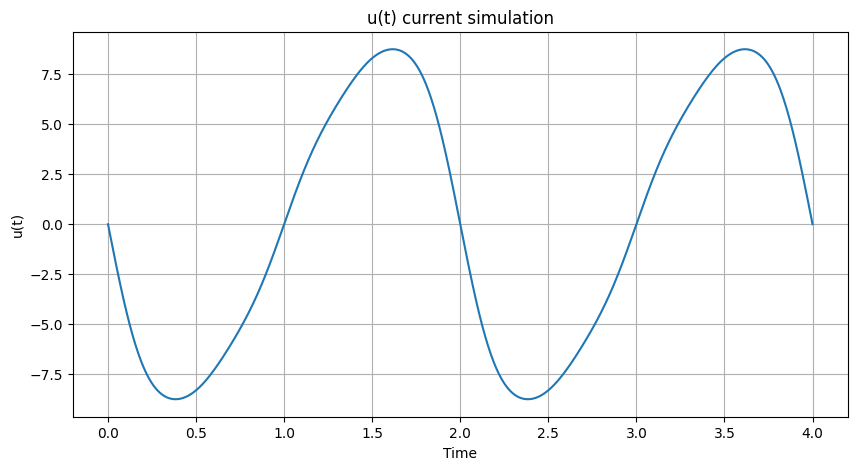

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|█████                                        | 1/9 [00:12<01:41, 12.67s/it]

Solving nonlinear variational problem.


 22%|██████████                                   | 2/9 [00:25<01:31, 13.04s/it]

Solving nonlinear variational problem.


 33%|███████████████                              | 3/9 [00:37<01:13, 12.24s/it]

Solving nonlinear variational problem.


 44%|████████████████████                         | 4/9 [00:46<00:54, 10.91s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████                    | 5/9 [00:57<00:44, 11.06s/it]

Solving nonlinear variational problem.


 67%|██████████████████████████████               | 6/9 [01:12<00:37, 12.37s/it]

Solving nonlinear variational problem.


 78%|███████████████████████████████████          | 7/9 [01:30<00:28, 14.39s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████     | 8/9 [01:46<00:14, 14.92s/it]

Solving nonlinear variational problem.


100%|█████████████████████████████████████████████| 9/9 [01:59<00:00, 13.33s/it]


In [9]:
if __name__ == "__main__":
    main()